# GEOS 505: Problem Set 3

### Background:

As part of your thesis, you are using a physics-based model to predict how the timing and amount of snow water storage in the Boise River Basin will change under alternative future scenarios of climate. You have your model up and running and presented preliminary results for the first time at a recent committee meeting. One of your committee members works with the Idaho NRCS snow survey and points out that your results would be more impactful if you could present them in the context of historical observations of snow water equivalent (SWE). In particular, your committee wants you to plot your simulations on top of historical SNOTEL climatology, presented as follows: 

<img src="../img/trinity_mtn-id-wteq-por.png" alt="Trinity Mtn. SNOTEL" width="1000" style="display: block; margin: 0 auto"/>

This figure, which can be generated on the NRCS website for any SNOTEL site and many water supply basins. This particular image is the 30 year "normals" for the 1991-2020 timeframe at Trinity Mountain SNOTEL site in the Upper Boise. The plot contains a water-year oriented plot of the following items:

- The median SWE vs time,
- The median maximum annual SWE on April 1, 
- The minimum SWE vs time,
- The maximum SWE vs time, and
- Filled in ranges for SWE quintiles (bottom 20%, 20-40%, 40-60%, 60-80%, and top 20%) vs time.

### Problem: 

Your hypothetical task for your thesis and the task for this problem set is to reproduce the above figure in a way that would allow you to analyze and plot historical data at a variety of SNOTEL sites, and in a way that would allow you to plot the corresponding version of this plot with simulated data for a future climate. As such, the expected outcome of this notebook is code that produces an image that looks similar to the above. You may certainly use an alternative color scheme, but make sure that the elements of the plot are labeled.

The outline of the steps is provided below, along with some helpful suggestions of `numpy` and `matplotlib` functions that you will likely need.

### 1. Imports and Definitions

In [1]:
from datetime import datetime
from dataretrieval import nwis
from metloom.pointdata import SnotelPointData
from metloom.variables import SnotelVariables

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

startDate = '1985-10-01'
endDate = '2025-09-30'

startDate_dt = datetime.strptime(startDate, '%Y-%m-%d')
endDate_dt = datetime.strptime(endDate, '%Y-%m-%d')

# Metloom Variables
snotel_stn = '830:ID:SNTL' # Trinity Mountain Snotel Station
snotel_pnt = SnotelPointData(station_id=snotel_stn, name='TrinityMtn')

variables = [snotel_pnt.ALLOWED_VARIABLES.SWE]

### 2. Load the Data and Verify

In [2]:
df_snotel = snotel_pnt.get_daily_data(startDate_dt, endDate_dt, variables)
df_snotel


,,geometry,SWE,SWE_units,datasource
datetime,site,,,,
1985-10-01 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-02 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-03 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-04 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
1985-10-05 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
...,...,...,...,...,...
2025-09-26 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-27 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS
2025-09-28 08:00:00+00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS


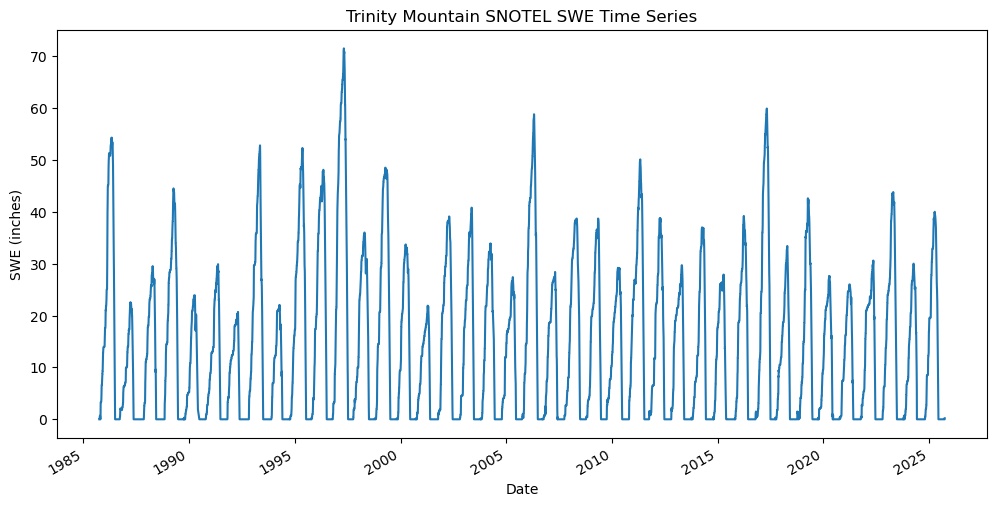

In [3]:
df_snotel.reset_index(level='site', inplace=True)
df_snotel['SWE'].plot(title='Trinity Mountain SNOTEL SWE Time Series', ylabel='SWE (inches)', xlabel='Date', figsize=(12,6))
plt.show()

### 3. Prep Data and Preallocate Storage

In [4]:
nYears = (endDate_dt.year - startDate_dt.year) + 1
swe_time_series = np.full((nYears, 365), np.nan)  # add nans to keep structure if missing data

In [19]:
# organize dataframse by water year and day of water year
df = df_snotel.copy()
df.index = pd.to_datetime(df.index).tz_localize(None) # remove timezone bc errors 

# water year
def water_year(d):
    return d.year + 1 if d.month >= 10 else d.year

df["WY"] = df.index.map(water_year)

# day of water year
def dowy_from_wy(row):
    wy_start = datetime(row["WY"] - 1, 10, 1)
    return (row.name - wy_start).days + 1

df["DOWY"] = df.apply(dowy_from_wy, axis=1)
df = df[df["DOWY"] <= 365]
df

,site,geometry,SWE,SWE_units,datasource,WY,DOWY
datetime,,,,,,,
1985-10-01 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,1986,1
1985-10-02 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,1986,2
1985-10-03 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,1986,3
1985-10-04 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,1986,4
1985-10-05 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,1986,5
...,...,...,...,...,...,...,...
2025-09-26 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,2025,361
2025-09-27 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,2025,362
2025-09-28 08:00:00,830:ID:SNTL,POINT Z (-115.43818 43.62903 7790),0.0,in,NRCS,2025,363


In [20]:
# add water year SWE data to swe_time_series array
# rows = water years, columns = days of water years 

unique_wy = df["WY"].unique()

# Fill SWE data by water year and day of water year
for i, wy in enumerate(unique_wy):
    sub = df[df["WY"] == wy]
    # subtract 1 because DOWY starts at 1
    indices = sub["DOWY"].values - 1
    swe_time_series[i, indices] = sub["SWE"].values

print(np.isnan(swe_time_series[:, 0]).sum(), "out of", swe_time_series.shape[0], "years have NaN on Oct 1")
swe_time_series

1 out of 41 years have NaN on Oct 1


array([[0. , 0. , 0. , ..., 1.8, 1.9, 2. ],
       [2.1, 2. , 2. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.2],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(41, 365))

In [22]:
# get data for 1991-2000
wy_index = np.arange(startDate_dt.year + 1, endDate_dt.year + 2)
year_mask = (wy_index >= 1991) & (wy_index <= 2020)
subset_data = swe_time_series[year_mask, :]  # shape: (30, 365)

### 4. Analyze Data

In [23]:
# analyze SWE data
max_SWE = np.max(subset_data,axis=0)
min_SWE = np.min(subset_data,axis=0)

median_SWE = np.median(subset_data,axis=0)


q20 = np.nanpercentile(subset_data, 20, axis=0)
q40 = np.nanpercentile(subset_data, 40, axis=0)
q60 = np.nanpercentile(subset_data, 60, axis=0)
q80 = np.nanpercentile(subset_data, 80, axis=0)

In [24]:
# april 1st SWE statistics
april1_dowy = (pd.Timestamp('2000-04-01') - pd.Timestamp('1999-10-01')).days + 1
median_max_swe_april1 = np.nanmedian(subset_data[:, april1_dowy-1])

### 5. Create Plot

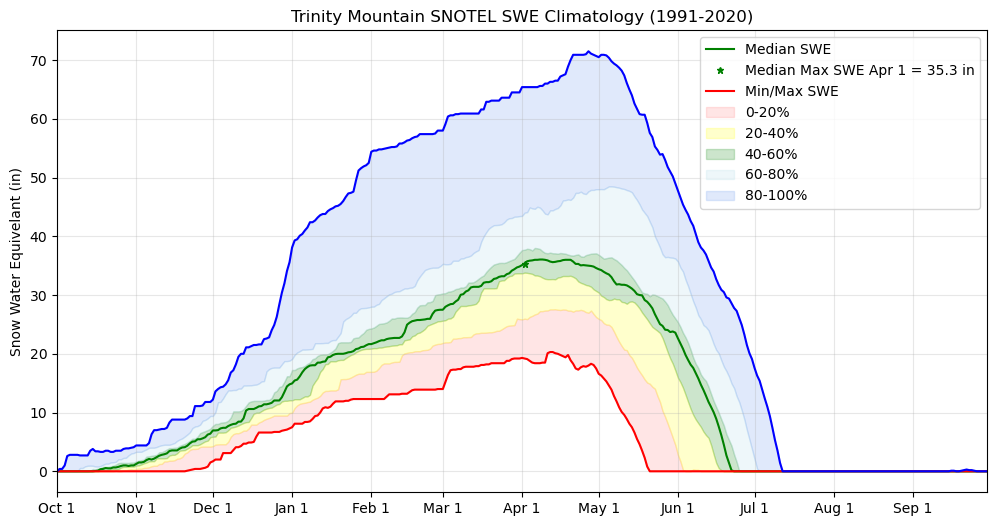

In [28]:
fig, ax = plt.subplots(figsize=(12,6))

dowy = np.arange(1, 366) # for x-axis

# median
ax.plot(dowy, median_SWE, label='Median SWE', color='green')
april1_dowy = (pd.Timestamp('2000-04-01') - pd.Timestamp('1999-10-01')).days + 1
median_april1 = np.nanmedian(subset_data[:, april1_dowy-1])
ax.plot(april1_dowy, median_april1, '*', color='green', markersize=5,
        label=f'Median Max SWE Apr 1 = {median_april1:.1f} in')

# min/max
ax.plot(dowy, min_SWE, color='red', linestyle='-', label='Min/Max SWE')
ax.plot(dowy, max_SWE, color='blue', linestyle='-')

# quantiles
ax.fill_between(dowy, min_SWE, q20, color='red', alpha=0.1, label='0-20%')
ax.fill_between(dowy, q20, q40, color='yellow', alpha=0.2, label='20-40%')
ax.fill_between(dowy, q40, q60, color='green', alpha=0.2, label='40-60%')
ax.fill_between(dowy, q60, q80, color='lightblue', alpha=0.2, label='60-80%')
ax.fill_between(dowy, q80, max_SWE, color='cornflowerblue', alpha=0.2, label='80-100%')

# xticks as months
water_year_start = pd.Timestamp('2000-10-01')  
first_of_months = pd.date_range(water_year_start, periods=12, freq='MS')
month_ticks = (first_of_months - water_year_start).days + 1
month_labels = first_of_months.strftime('%b 1')  # shuld be Oct 1
ax.set_xticks(month_ticks)
ax.set_xticklabels(month_labels)


ax.set_ylabel('Snow Water Equivelant (in)')
ax.set_title('Trinity Mountain SNOTEL SWE Climatology (1991-2020)')
ax.set_xlim(1, 365)
ax.grid(alpha=0.3)
ax.legend(loc='upper right')


plt.show()